In [1]:
import os
import math
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

# Setup

In [2]:
train_df = pd.read_csv("../input/ndsc-beginner/train.csv")
train_df = train_df.sample(frac=1.)
val_df = train_df[:int(0.01*len(train_df))]
train_df = train_df[int(0.01*len(train_df)):]
val_df.head()

,itemid,title,Category,image_path
352221,1734435160,cuci gudang big size lace u002f brokat dress f...,24,fashion_image/12f77e7bdfacff949d48b8aa479b50ee
487323,1113674554,fashion wanita kaos tank top tanpa lengan crew...,28,fashion_image/f3df762314b1d9c1f6b6920941df5efe
181782,1501600937,makeup beili x06 black eye shadow tampered ble...,9,beauty_image/5eb502ec1f649f150210620912e2caca.jpg
458885,1107412982,vooo blus sifon wanita o neck lengan panjang m...,27,fashion_image/50fecf63b907059ffc19567739dc71d4
639693,132626436,ready iphone 7 plus,31,mobile_image/9763be92fe7a54769f2e61ea08533780.jpg


In [3]:
# Embdedding setup, save it in a dictionary for easier queries
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print(coefs.shape)

print('Found %s word vectors.' % len(embeddings_index))

2196018it [02:33, 14283.61it/s]

(300,)
Found 2196017 word vectors.


In [4]:
len(values)

301

In [5]:
# Convert values to embeddings
def text_to_array(text):
    empyt_emb = np.zeros(300)
    text = text[:-1].split()[:300]
    embeds = [embeddings_index.get(x, empyt_emb) for x in text]
    embeds += [empyt_emb] * (300 - len(embeds))
    return np.array(embeds)

In [6]:
val_df.shape

(6666, 4)

In [7]:
val_vects = np.array([text_to_array(X_text) for X_text in (val_df["title"][:])])
val_y_labels = np.array(val_df["Category"])
#val_y = np.zeros((len(val_y_labels), 58))
#val_y[np.arange(len(val_y_labels)), val_y_labels] = 1

In [8]:
val_vects.shape

(6666, 300, 300)

In [9]:
# Understand what a batch is made of
batch_size = 128
i = 0
texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
text_arr = np.array([text_to_array(text) for text in texts])
batch_labels = np.array(train_df["Category"][i*batch_size:(i+1)*batch_size])
batch_targets = np.zeros((batch_size, 58))
batch_targets[np.arange(batch_size), batch_labels] = 1

print(text_arr.shape)
print(batch_targets.shape)

(128, 300, 300)
(128, 58)


In [10]:
# Write generator, which 
batch_size = 128

def batch_gen(train_df):
    n_batches = math.floor(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.)  # Shuffle the data.
        for i in range(n_batches):
            texts = train_df.iloc[i*batch_size:(i+1)*batch_size, 1]
            text_arr = np.array([text_to_array(text) for text in texts])
            batch_labels = np.array(train_df["Category"][i*batch_size:(i+1)*batch_size])
            yield text_arr, batch_labels

# Training

In [11]:
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Dense, Bidirectional, Activation, Dropout, ConvLSTM2D
from keras.layers import Conv3D, Flatten, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history["loss"], color="purple")
    plt.plot(history.history["acc"], color="blue")
    plt.plot(history.history["val_loss"], color="red")
    plt.plot(history.history["val_acc"], color="green")
    plt.xlim(0,)
    plt.ylim(0.5,1.5)
    plt.legend(['loss', 'acc', "val_loss", "val_acc"], loc='upper right')
    plt.show()

In [13]:
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True),
                        input_shape=(300,300)))
model.add(Dropout(0.05))
model.add(Bidirectional(CuDNNLSTM(128)))
model.add(Dense(58, kernel_initializer='normal'))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
mg = batch_gen(train_df)
history = model.fit_generator(mg, epochs=80,
                    steps_per_epoch=1000,
                    validation_data=(val_vects, val_y_labels),
                    verbose=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/80
1000/1000 [==============================] - 203s 203ms/step - loss: 1.3458 - acc: 0.6022 - val_loss: 1.1509 - val_acc: 0.6493
Epoch 2/80
1000/1000 [==============================] - 197s 197ms/step - loss: 1.0836 - acc: 0.6692 - val_loss: 1.0800 - val_acc: 0.6701
Epoch 3/80
1000/1000 [==============================] - 198s 198ms/step - loss: 1.0357 - acc: 0.6806 - val_loss: 1.0452 - val_acc: 0.6784
Epoch 4/80
1000/1000 [==============================] - 198s 198ms/step - loss: 1.0081 - acc: 0.6862 - val_loss: 1.0224 - val_acc: 0.6817
Epoch 5/80
1000/1000 [==============================] - 198s 198ms/step - loss: 0.9850 - acc: 0.6931 - val_loss: 1.0021 - val_acc: 0.6833
Epoch 6/80
1000/1000 [==============================] - 198s 198ms/step - loss: 0.9542 - acc: 0.6989 - val_loss: 0.9818 - val_acc: 0.6892
Epoch 7/80
1000/1000 [==============================] - 198s 198ms/step - loss: 0.9392 - acc: 0.7036 - val_loss: 0.9655 - va

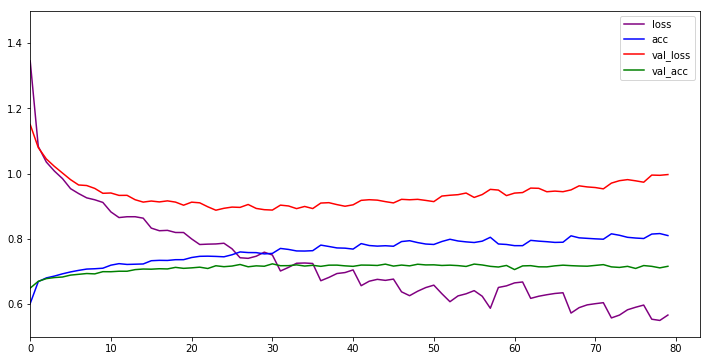

In [15]:
plot_history(history)

In [16]:
history = model.fit_generator(mg, epochs=1,
                    steps_per_epoch=1000,
                    validation_data=(val_vects, val_y_labels),
                    verbose=True)

Epoch 1/1
1000/1000 [==============================] - 198s 198ms/step - loss: 0.5791 - acc: 0.8061 - val_loss: 0.9922 - val_acc: 0.7166


# Inference

In [17]:
# Make the prediction from the model
batch_size = 256
def batch_gen(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i*batch_size:(i+1)*batch_size, 1]
        text_arr = np.array([text_to_array(text) for text in texts])
        yield text_arr

test_df = pd.read_csv("../input/ndsc-beginner/test.csv")
test_df["Supercategory"] = test_df["image_path"].str[0]
supercats = np.array(test_df["Supercategory"])
supercat_dict = {
    "b" : np.array([1]*17 + [0]*14 + [0]*27),
    "f" : np.array([0]*17 + [1]*14 + [0]*27),
    "m" : np.array([0]*17 + [0]*14 + [1]*27)
}

all_preds = []
for x in tqdm(batch_gen(test_df)):
    all_preds.extend(model.predict(x))

674it [06:02,  2.23it/s]


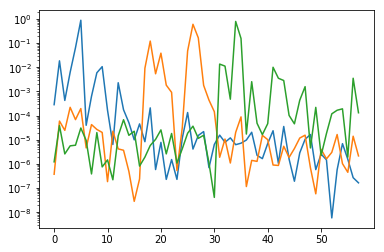

In [18]:
import matplotlib.pyplot as plt
plt.plot(all_preds[0])
plt.plot(all_preds[int(len(all_preds)/2)])
plt.plot(all_preds[-1])
plt.yscale("log")
plt.show()

In [19]:
print(np.shape(all_preds))
y_te = [np.argmax(pred) for pred,supercat in zip(all_preds,supercats)]

(172402, 58)


In [20]:
submit_df = pd.DataFrame({"itemid": test_df["itemid"], "Category": y_te})
submit_df.to_csv("submission.csv", index=False)

In [21]:
submit_df.head()

,itemid,Category
0,370855998,5
1,637234604,5
2,690282890,5
3,930913462,5
4,1039280071,5


In [22]:
submit_df.tail()

,itemid,Category
172397,1781957365,38
172398,1839851276,31
172399,955369303,35
172400,1638035772,33
172401,1498091427,34
